## 2章: Open Bandit Pipelineを用いた意思決定モデルの学習/性能評価の実装

この実装例は主に次のステップで構成される。

1. ある古い意思決定モデル$\pi_b$が稼働することで収集されたログデータを模した工データを生成する
2. トレーニングデータを用いて意思決定モデルを学習し、バリデーションデータに対して行動を選択する
3. 学習した意思決定モデルの性能を、バリデーションデータを用いて推定する

In [1]:
# 必要なパッケージやモジュールをインポート
from sklearn.linear_model import LogisticRegression

from obp.dataset import (
    SyntheticBanditDataset,
    logistic_reward_function,
    linear_behavior_policy
)
from obp.policy import IPWLearner, Random
from obp.ope import (
    OffPolicyEvaluation, 
    RegressionModel,
    InverseProbabilityWeighting as IPS,
    DoublyRobust as DR
)

### 1. 人工データの生成

In [2]:
# `SyntheticBanditDataset`を用いて人工データを生成する
dataset = SyntheticBanditDataset(
    n_actions=3, # 人工データにおける行動の数
    dim_context=3, # 人工データにおける特徴量の次元数
    reward_function=logistic_reward_function, # 目的変数を生成する関数
    behavior_policy_function=linear_behavior_policy, # 過去の意思決定モデル\pi_bによる行動選択確率を生成する関数
    random_state=12345,
)

# トレーニングデータとバリデーションデータを生成する
training_data = dataset.obtain_batch_bandit_feedback(n_rounds=10000)
validation_data = dataset.obtain_batch_bandit_feedback(n_rounds=10000)

# `training_data`の中身を確認する
training_data

{'n_rounds': 10000,
 'n_actions': 3,
 'context': array([[-0.20470766,  0.47894334, -0.51943872],
        [-0.5557303 ,  1.96578057,  1.39340583],
        [ 0.09290788,  0.28174615,  0.76902257],
        ...,
        [ 0.42468038,  0.48214752, -0.57647866],
        [-0.51595888, -1.58196174, -1.39237837],
        [-0.74213546, -0.93858948,  0.03919589]]),
 'action_context': array([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]]),
 'action': array([0, 1, 0, ..., 0, 0, 2]),
 'position': None,
 'reward': array([0, 1, 1, ..., 0, 0, 0]),
 'expected_reward': array([[0.62697512, 0.66114455, 0.66545218],
        [0.73402729, 0.92955625, 0.94007301],
        [0.72522191, 0.79973865, 0.85946747],
        ...,
        [0.74929842, 0.68243742, 0.77801157],
        [0.3583225 , 0.25252838, 0.16625489],
        [0.41919738, 0.52158296, 0.41624562]]),
 'pscore': array([0.25534252, 0.36715004, 0.25534252, ..., 0.25534252, 0.25534252,
        0.37750744])}

### 2. 意思決定モデルの学習（Off-Policy Learning; OPL）

トレーニングデータを用いて次の2つの意思決定意思決定モデルを学習し、バリデーションデータに対して目的変数を最大化する行動を選択する。

1. IPWLearner+ロジスティック回帰
2. ランダム意思決定モデル

In [3]:
%%time
# 「IPWLearner+ロジスティック回帰」を定義
ipw_learner = IPWLearner(
    n_actions=dataset.n_actions,
    base_classifier=LogisticRegression(C=100, random_state=12345)
)

# トレーニングデータを用いて、意思決定意思決定モデルを学習
ipw_learner.fit(
    context=training_data["context"], # 特徴量
    action=training_data["action"], # 過去の意思決定モデル\pi_bによる行動選択
    reward=training_data["reward"], # 観測される目的変数
    pscore=training_data["pscore"], # 過去の意思決定モデル\pi_bによる行動選択確率(傾向スコア)
)

# バリデーションデータに対して行動を選択する
action_choice_by_ipw_learner = ipw_learner.predict(
    context=validation_data["context"],
)

CPU times: user 66.3 ms, sys: 1.8 ms, total: 68.1 ms
Wall time: 66.9 ms


In [4]:
%%time
# ランダム意思決定モデルを定義
random = Random(n_actions=dataset.n_actions)

# バリデーションデータに対する行動選択確率を計算する
action_choice_by_random = random.compute_batch_action_dist(
    n_rounds=validation_data["n_rounds"]
)

CPU times: user 300 µs, sys: 94 µs, total: 394 µs
Wall time: 299 µs


### 3. 意思決定モデルの性能評価（Off-Policy Evaluation; OPE）

2つの意思決定意思決定モデルの性能を、バリデーションデータを用いて評価する。オフライン評価には、IPS推定量とDR推定量を用いる。

In [5]:
%%time
# DR推定量に必要な目的変数予測モデルを得る
# opeモジュールに実装されている`RegressionModel`に好みの機械学習手法を与えば良い
regression_model = RegressionModel(
    n_actions=dataset.n_actions, # 行動の数
    base_model=LogisticRegression(C=100, random_state=12345), # ロジスティック回帰を使用
)

# `fit_predict`メソッドにより、バリデーションデータにおける期待報酬を推定
estimated_rewards_by_reg_model = regression_model.fit_predict(
    context=validation_data["context"], # 特徴量
    action=validation_data["action"], # 過去の意思決定モデル\pi_bによる行動選択
    reward=validation_data["reward"], # 観測される目的変数
    random_state=12345,
)

CPU times: user 60.8 ms, sys: 23.4 ms, total: 84.2 ms
Wall time: 14 ms


In [6]:
# 意思決定モデルの性能評価を一気通貫で行うための`OffPolicyEvaluation`を定義する
ope = OffPolicyEvaluation(
    bandit_feedback=validation_data, # バリデーションデータ
    ope_estimators=[IPS(estimator_name="IPS"), DR()] # 使用する推定量
)

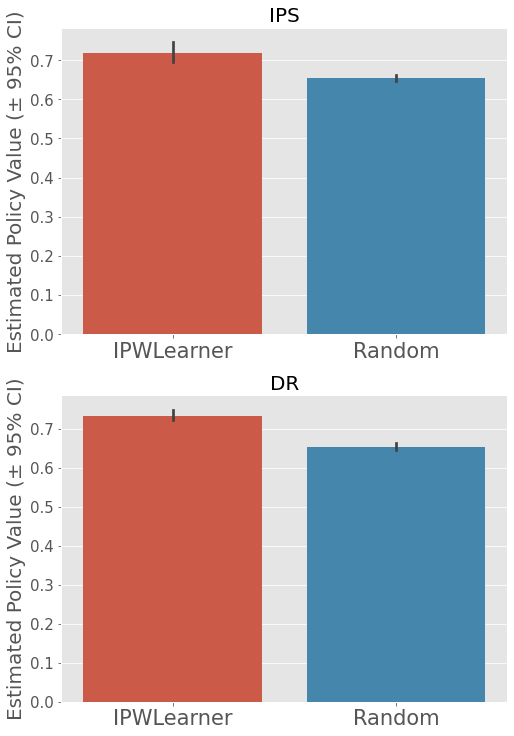

In [7]:
# IPWLearner+ロジスティック回帰の性能をIPS推定量とDR推定量で評価
ope.visualize_off_policy_estimates_of_multiple_policies(
    policy_name_list=["IPWLearner", "Random"],
    action_dist_list=[
        action_choice_by_ipw_learner, # IPWLearnerによるバリデーションデータに対する行動選択
        action_choice_by_random, # ランダム意思決定モデルによるバリデーションデータに対する行動選択
    ],
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model, # DR推定量に必要な期待報酬推定値
    random_state=12345,
)

### どの推定量を信じたとしても、IPWLearner(new_decision_making_model)がランダム意思決定モデル(random)の性能を上回るという結果が得られた

### 4. 最後に2つの意思決定モデルの真の性能を確認する

In [8]:
# ipw_learnerとrandomの真の性能を計算する
# これは、`SyntheticBanditDataset`の`cal_ground_truth_policy_value`メソッドを呼び出すことで計算できる
performance_of_ipw_learner = dataset.calc_ground_truth_policy_value(
    expected_reward=validation_data['expected_reward'], # バリデーションデータにおける期待報酬
    action_dist=action_choice_by_ipw_learner, # 評価対象の意思決定モデルによる行動選択確率
)
performance_of_random = dataset.calc_ground_truth_policy_value(
    expected_reward=validation_data['expected_reward'], # バリデーションデータにおける期待報酬
    action_dist=action_choice_by_random, # 評価対象の意思決定モデルによる行動選択確率
)

print(f'IPWLearner+ロジスティック回帰の性能: {performance_of_ipw_learner}')
print(f'ランダム意思決定モデルの性能: {performance_of_random}')

IPWLearner+ロジスティック回帰の性能: 0.725425479831354
ランダム意思決定モデルの性能: 0.6525795707041967
